# Analysis of lichess games

Thomas BOUYER & Bastian NADLER (dataset by George Kanellos)

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/danger.svg">
>   <img alt="Danger" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/danger.svg">
> </picture><br>
>
> Error on key "White_ts_mistakes" in the doc ! In the .csv file, it's "White_ts_mistake" (without the "s") !<br>

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/warning.svg">
>   <img alt="Warning" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/warning.svg">
> </picture><br>
>
> Part 4 of this notebook is very resource intensive<br>
> and can not run on free tier of Google Colab.<br>
> It is recommended to run it on a computer with at least 32GB of RAM and a good CPU.<br>
> This notebook was tested with python 3.11 on:
> - laptop 32GB RAM, i9-13900H
> - desktop 128GB RAM, r9-5950X
> - azure NDv2 512GB RAM, 2x Epyc 9654


In [1]:
import os
import gc

from IPython.display import display, HTML, DisplayHandle

import chess
import chess.svg
import numpy as np

from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

DATA_DIR = "data"
FILE_NAME = "Sept_20_analysis.csv"


In [2]:
def show_board(*fen: str) -> DisplayHandle:
    """Returns a DisplayHandle of one or more chess boards given FENs strings"""
    boards = [chess.Board(f) for f in fen]
    no_wrap_div = '<div style="white-space: nowrap">' + '{} '*len(boards) + '</div>'
    return display(HTML(no_wrap_div.format(*(chess.svg.board(b, size=350,
            colors={"square light": "#eeedd5",
                    "square dark": "#7c945d",
                    "square dark lastmove": "#bdc959",
                    "square light lastmove": "#f6f595",}) for b in boards))))


## ToC

Because there is so much to say about this dataset, the analysis was not performed in the order of the questions. Many additional questions were asked and answered along the way.

1. The data
2. The openings
    - 2.1. Most popular openings by rating
    - Uncommon openings at the low rating level
    - 2.2. Which openings show the biggest change in popularity between ratings?
    - Biggest winners
    - Biggest losers
    - 2.3. Which are the most successful openings for each color? (Q2)
3. The players (and their moves)
    - 3.1. How often do games flip?
    - 3.2. What is the relationship between ELO rating and inaccurate moves? (Q1)
    - Blunders
    - What about lesser mistakes?
    - 3.3. How does time pressure affect the move quality? (best Q4 candidate)
4. Predicting the game outcome based on the available information (Q3)
5. Future considerations

## 1. The data

Chess stands is one of the top strategy game. Feeling the need to delve into it, let's embarked on an analysis. The dataset came to life through an examination of games from September 2020 in the lichess game database, a period coinciding with the lockdown.

The process involved a meticulous review of games by OP, during which people crafted variables aimed at capturing intriguing aspects. Metrics such as the frequency of blunders by players and the quality of moves made during substantial time investments were among the variables generated. Only games with evaluations by lichess found their way into the dataset.

Now, let's turn our attention to the games at our disposal and explore some of the variables in this notebook. But before we dive in, a snapshot of the games in question:

In [59]:
filepath = os.path.join(DATA_DIR, FILE_NAME)

# load and create spark dataframe
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
df: DataFrame = spark.read.csv(filepath, header=True, inferSchema=True)

df.show(5)
print(f"Number of rows: {df.count()}")


+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

In [4]:
def format_K_axis_label(value, _) -> str:
    if value >= 1e3:
        return f"{value / 1e3:.0f}K"
    return str(value)


In [5]:
should_drop_correspondence = True # this might make sense
if should_drop_correspondence:
    # drop all entries where Game_type is Correspondence
    df = df.filter(df.Game_type != "Correspondence")


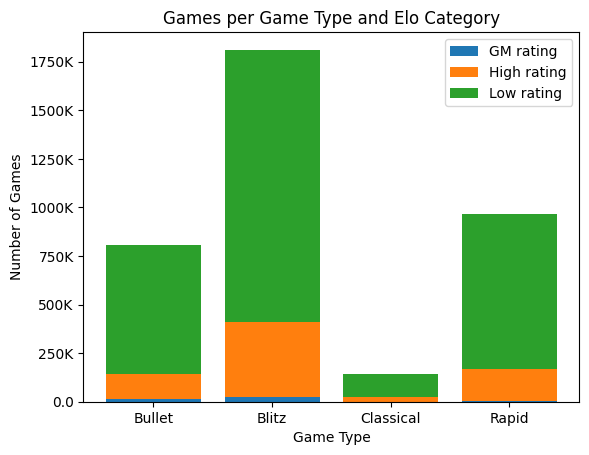

In [6]:
game_types = df.select("Game_type").distinct().rdd.flatMap(lambda x: x).collect()
elo_categories = df.select("Black_elo_category").distinct().rdd.flatMap(lambda x: x).collect()
elo_categories = sorted(elo_categories, key=lambda x: df.filter(df["Black_elo_category"] == x).count())

# create stacked data: {elo_category: [count, count, ...]}
stacked_data = {elo_category: [] for elo_category in elo_categories}
bottom_values = np.zeros(len(game_types))

for elo_category in elo_categories:
    for game_type in game_types:
        # populate stacked data per game type
        c = df.filter((df["Game_type"] == game_type) & (df["Black_elo_category"] == elo_category)).count()
        stacked_data[elo_category].append(c)

r = np.arange(len(game_types))  # the x locations for the groups
_, ax = plt.subplots()  # we do not need the figure handle here (1 subplot only)

for i, elo_category in enumerate(elo_categories):
    # plot stacked bar chart
    ax.bar(r, stacked_data[elo_category], bottom=bottom_values, label=elo_category)
    bottom_values += np.array(stacked_data[elo_category])  # update bottom values

ax.set_xlabel('Game Type')
ax.set_ylabel('Number of Games')
ax.set_title('Games per Game Type and Elo Category')
ax.set_xticks(r)
ax.set_xticklabels(game_types)
ax.legend()

# format y axis to be in Ks
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(format_K_axis_label))

plt.show()


We have roughly 3.7 million games in our dataset, the majority of which are Blitz games. The GM rated games are very few in comparison to the other categories but we will try to analyse the data as percentage of the totals in order to be able to compare across rating categories.


## 2. The openings

### 2.1. The most popular openings by rating

An interesting question is whether the openings chosen by higher rated players differ significantly to the ones chosen by us lesser mortals.

We kick things off with an easy analysis where we just have a look at the most popular openings broken down by rating:

In [7]:
# we have similar entries for openings, for example:
# "Sicilian Defense: Bowdler Attack" and "Sicilian Defense: Bowdler Attack, B20"
# we want to group these together by removing everything after : and ,
# (sometimes, there is a , before the : ...)
# splicing on both (w/o particular order) ensures that we only get the first part of the string


def get_opening(opening: str) -> str:
    """Returns the opening name without the variation"""
    return opening.split(":")[0].split(",")[0]


get_opening_udf = F.udf(get_opening, StringType())
df = df.withColumn("Cleaned_Opening", get_opening_udf(df["Opening"]))

cleaned_openings = df.select("Cleaned_Opening").distinct().rdd.flatMap(lambda x: x).collect()
openings = df.select("Opening").distinct().rdd.flatMap(lambda x: x).collect()
print(f"{len(openings)} -> {len(cleaned_openings)}")


2789 -> 171


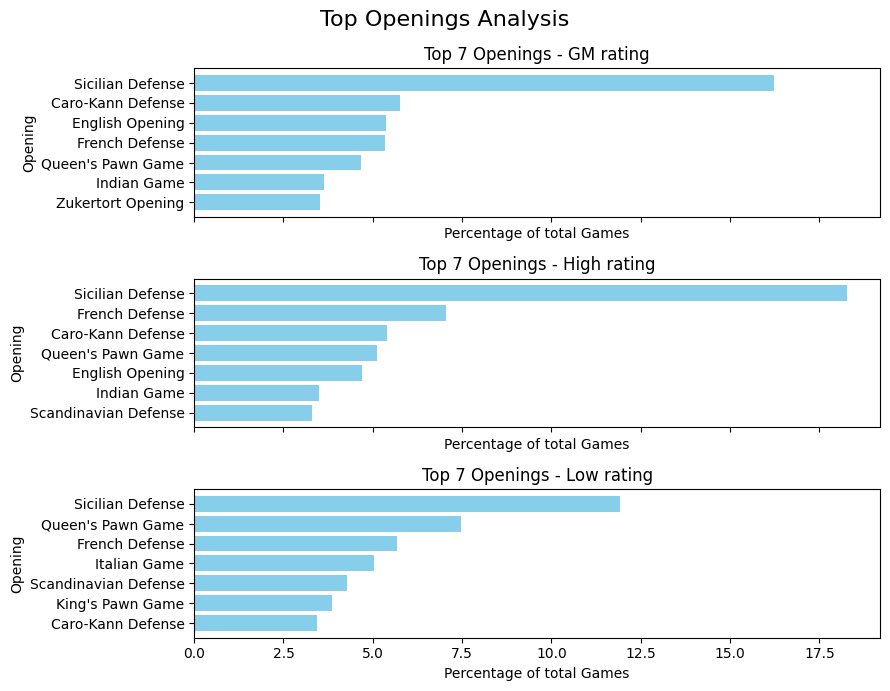

In [8]:
top_openings_count = 7

# share x axis
# so that the percentage of games is comparable between the different rating categories
fig, axs = plt.subplots(len(elo_categories), 1, figsize=(3 * len(elo_categories), top_openings_count), sharex=True)

# iterate through each rating category
for i, elo_category in enumerate(elo_categories):
    # filter data for the current rating category
    subset_df = df.filter(F.col("Black_elo_category") == elo_category)

    # count the occurrences of each opening
    opening_counts = subset_df.groupBy("Cleaned_Opening").count().orderBy(F.desc("count")).limit(top_openings_count)
    total_games = subset_df.count()
    opening_counts = opening_counts.withColumn("Percentage", F.col("count") / total_games * 100)

    # plot horizontal bar chart
    axs[i].barh(list(reversed(opening_counts.select("Cleaned_Opening").rdd.flatMap(lambda x: x).collect())),
                list(reversed(opening_counts.select("Percentage").rdd.flatMap(lambda x: x).collect())), color="skyblue")
    axs[i].set_title(f"Top {top_openings_count} Openings - {elo_category}")
    axs[i].set_xlabel("Percentage of total Games")
    axs[i].set_ylabel("Opening")

fig.suptitle("Top Openings Analysis", fontsize=16)
plt.tight_layout()
plt.show()


**The Sicilian rules!**

The results are in, Long live the Sicilian!

Undoubtedly, it stands out as the most favored opening for playing as black across all three of our rating categories.
For those less acquainted with the nuances of chess, the Sicilian Defense reigns supreme as the most commonly employed defense against White's 1.e4 move. To provide a clearer picture, these are the initial moves made by both players:

In [9]:
show_board("rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2")


The popularity of this defense at all skill levels stems from the significant winning opportunities it provides for the black side. However, in chess, gaining something often involves giving something in return, and thus, there is an increased risk of losing as well. At lower levels, 1.e4 is the more prevalent starting move.

A noticeable trend in our data reveals that as ratings increase, **players opt for 1.e4 less frequently**. This move is commonly recommended for beginners, as it claims central space and opens up diagonals for both the bishop and the queen.

In [10]:
show_board("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 1")


Among the top 10 favorite openings for lower-rated players, 8 commence with 1.e4 (exceptions being the Queen’s Pawn Game and the English Opening). For higher-rated players, this number decreases to 6 (with the Indian Game and Queen’s Gambit Declined added to the exception list), and for GM ratings, it further drops to 5 (including the Zukertort Opening and King’s Indian Defense).

#### Uncommon Openings at Lower Ratings

While there are similarities in the three lists, two openings stand out as particularly popular in lower-rated games:

1. King’s Pawn Game
2. Philidor Defense

Let’s delve into them.

**King’s Pawn Game**

As the name implies, this category involves games with the initial move of the King’s Pawn (e2 pawn for White). However, these are not the usual openings; instead, they feature uncommon starting moves. Here are two examples:


In [11]:
show_board("rnbqkbnr/pppp1ppp/8/4p2Q/4P3/8/PPPP1PPP/RNB1KBNR w KQkq - 1 2", "rnbqkbnr/pppp1ppp/8/4p3/4P3/3P4/PPP2PPP/RNBQKBNR w KQkq - 1 2")


Both choices by White are unconventional, with apparent drawbacks:
In the first example, the Queen is susceptible to attack after 2…Nc6 and 3…Nf6. A good principle is to develop other pieces before the Queen.
In the second example, the move d3 blocks the bishop on f1 and overprotects e4, which was not under threat. White could fare better by developing a piece (either knight or bishop).

**Philidor Defense**

The Philidor Defense stands as one of the oldest defenses against 1.e4. A solid defense, it is still employed when players seek to avoid highly theoretical lines in the Spanish or Italian Game. While rarely seen at the top level, even world champions like Caruana Carlsen have employed it, as witnessed in 2011.

In [12]:
show_board("rnbqkbnr/ppp2ppp/3p4/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3")


### 2.2 Which openings show the biggest change in popularity between ratings?

This question builds upon the previous one, introducing some nuances. Here, we aim to examine how the popularity of different chess openings varies across distinct rating categories. In the earlier visualization, such analysis was limited to openings that ranked within the top 10 across all three rating groups.

_Regarding the methodology_ employed, the approach involved calculating the change for each opening based on the maximum percentage point difference observed across the various rating categories. For instance, if a particular opening, say X, had a prevalence of 3% in low-rated games, 5% in high-rated games, and 4% in Grandmaster-rated games, the calculated change for this opening would be 2 percentage points, derived from the difference between 5% and 3%.

In [13]:
# Initialize the opening_evolution dictionary
opening_evolution: dict[str, dict[str, float]] = {
    opening: {elo_category: 0.0 for elo_category in elo_categories}
    for opening in cleaned_openings
}

# iterate through each elo category
for i, elo_category in enumerate(elo_categories):
    # filter data for the current rating category
    subset_df = df.filter(F.col("Black_elo_category") == elo_category)
    total_games = subset_df.count()

    # count the occurrences of each opening and calculate percentages
    opening_counts = (
        subset_df
        .groupBy("Cleaned_Opening")
        .count()
        .withColumn("Percentage", F.col("count") / total_games * 100)
        .orderBy(F.desc("count"))
    )

    # Populate opening_evolution
    for row in opening_counts.collect():
        opening_evolution[row["Cleaned_Opening"]][elo_category] = row["Percentage"]


In [14]:
# a dict that only keeps the top_openings_count openings_evolution
top_opening_evolution = dict(sorted(opening_evolution.items(), key=lambda x: sum(x[1].values()), reverse=True)[:top_openings_count])


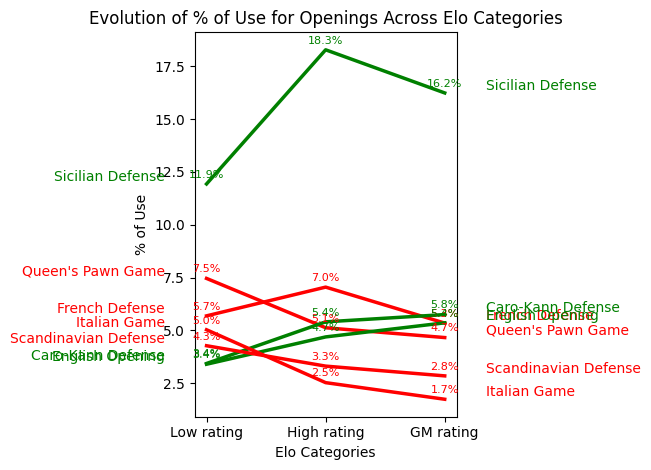

In [15]:
_, ax = plt.subplots()

# define colors for lines
marker_colors = {"up": "green", "down": "red"}

# iterate through each opening
for opening, evolution in top_opening_evolution.items():
    # Extract elo categories and percentages
    categories = list(evolution.keys())[::-1]
    percentages = list(evolution.values())[::-1]

    # plot lines indicating the trend
    trend_color = (
        marker_colors["up"]
        if percentages[-1] > percentages[0]
        else marker_colors["down"]
    )
    ax.plot(
        categories,
        percentages,
        marker="",  # no marker
        linestyle="-",
        linewidth=2.5,  # increase line thickness
        label=opening,
        color=trend_color,
    )

    # annotate the first points with the opening name
    ax.annotate(
        opening,
        xy=(categories[0], percentages[0]),
        textcoords="offset points",
        xytext=(-30, 0),
        ha="right",
        va="bottom",
        color=trend_color,
    )
    ax.annotate(
        opening,
        xy=(categories[-1], percentages[-1]),
        textcoords="offset points",
        xytext=(30, 0),
        ha="left",
        va="bottom",
        color=trend_color,
    )

    # annotate the last points with the percentage values
    for i, (cat, perc) in enumerate(zip(categories, percentages)):
        ax.annotate(
            f"{perc:.1f}%",  # display percentage with one decimal place
            xy=(cat, perc),
            xytext=(0, 3),  # adjust text offset for better visibility
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,  # set font size for percentage labels
            color=trend_color,
        )

ax.set_xlabel("Elo Categories")
ax.set_ylabel("% of Use")
ax.set_title("Evolution of % of Use for Openings Across Elo Categories")

plt.tight_layout()
plt.show()


### Biggest winners

**Always number 1: Sicilian Defense**

Undoubtedly leading the pack is the Sicilian Defense, standing head and shoulders above other openings. Not only is it the most widely adopted opening across all rating tiers, but it also exhibits the most significant surge in prevalence with increasing ratings. The Sicilian Defense sees a remarkable rise from appearing in 12% of low-rated games to 17% in high-rated matches and maintains a strong presence at 16% in Grandmaster-rated games. Quite astonishing!

**Consistently in Demand: English Opening, Caro-Kann Defense**

The English Opening and Caro-Kann Defense maintain consistent popularity across all rating categories, gaining even more traction as ratings ascend. The English Opening asserts control over the center, particularly the d5 square, and can transition into more conventional openings through moves like d4 and Nc3 by White. It demands a certain level of expertise due to its limited contribution to piece development compared to 1.d4 and 1.e4. Notably, the sixth game of the World Chess Championship between Fischer and Spassky saw a surprising 1.c4 move from Fischer, a staunch advocate of 1.e4, which later transposed into a Queen’s Gambit Declined.

The Caro-Kann Defense stands out as a respected and robust opening for Black, providing a secure foundation with fewer counterattacking opportunities compared to the Sicilian or the French. Renowned players, including world champions Vasily Smyslov and Anatoly Karpov, have successfully employed this strategy. One of the most memorable Caro-Kann moments occurred in the final game of the chess match between Garry Kasparov and Deep Blue. Kasparov's opening blunder was ruthlessly exploited by Deep Blue, marking a pivotal moment in realizing the impending dominance of machines in the chess world.

In [16]:
show_board("rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR w KQkq - 0 1", "rnbqkbnr/pp1ppppp/2p5/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2")


**Surging in Popularity: The King's Indian Defense**

The King's Indian Defense stands out as one of the most captivating chess openings. This hypermodern strategy sees Black willingly allowing White to establish control in the center initially, with the intention of later challenging that dominance.

Examining the second chart below reveals White's formidable position, boasting pawns on c4, d4, e4, f4, along with a developed knight and bishop. At first glance, it might seem like a sure victory for White, especially in the case of the "Four Pawns Attack" variation (despite being less formidable than it appears). However, the beauty of the King's Indian Defense lies in Black's ability to counterattack and achieve impressive outcomes.

This strategic approach has been embraced by chess world champions renowned for their aggressive playing style and their commitment to introducing imbalances in the position. Grandmasters such as Garry Kasparov, Bobby Fischer, and Mikhail Tal have all favored the King's Indian Defense as a means to play for a win with Black, showcasing its enduring appeal in the realm of chess.

In [17]:
show_board("rnbqkb1r/pppppp1p/5np1/8/2PP4/8/PP2PPPP/RNBQKBNR w KQkq - 1 1", "rnbq1rk1/ppp1ppbp/3p1np1/8/2PPPP2/2N5/PP2B1PP/R1BQK1NR w KQ - 1 1")


### Biggest losers

**Taking a dive: King's Pawn Opening**

Unsurprisingly, the popularity of the King's Pawn Opening sees a significant decline across various rating categories. This comes as no surprise, considering that more seasoned players often opt for alternative opening moves (1.d4, 1.c4, 1.Nf3) or venture into more conventional paths when initiating 1.e4, such as the Ruy Lopez, the Italian, the French, and so on.

### 2.3. Which are the most successful openings for each color?

With a substantial dataset at our disposal, we can delve into the success rates associated with different openings for both White and Black in chess. Traditionally, White enjoys the advantage of making the first move, a factor that Black endeavors to counteract. It's crucial to note that these are broad observations, and particularly in rapid time formats, outcomes can be unpredictable. To ensure statistical reliability, I've excluded openings with fewer than 50 000 instances from this analysis to mitigate the impact of exceptionally small sample sizes.

In [18]:
threshold_count = 50_000

# calculate win rates for each opening and color
opening_win_rates = (
    df.groupBy("Cleaned_Opening", "Result")
    .count()
    .groupBy("Cleaned_Opening")
    .agg(
        F.sum("count").alias("total_games"),
        F.sum(F.when(F.col("Result") == "1-0", F.col("count")).otherwise(0)).alias("white_wins"),
        F.sum(F.when(F.col("Result") == "0-1", F.col("count")).otherwise(0)).alias("black_wins"),
        F.sum(F.when(F.col("Result") == "1/2-1/2", F.col("count")).otherwise(0)).alias("draws"),
    )
    .filter(F.col("total_games") >= threshold_count)  # filter by count threshold
    .withColumn("white_win_rate", F.col("white_wins") / F.col("total_games"))
    .withColumn("black_win_rate", F.col("black_wins") / F.col("total_games"))
    .withColumn("draw_rate", F.col("draws") / F.col("total_games"))
    .select("Cleaned_Opening", "white_win_rate", "black_win_rate", "draw_rate")
    .fillna(0)  # replace NaN with 0 for cases where there are no wins
    .toPandas()  # convert to Pandas DataFrame for simplicity (this is less than 0.01MB in memory)
)

# Convert Pandas DataFrame to dictionary
opening_win_rates_dict = {
    row["Cleaned_Opening"]: {"white": row["white_win_rate"], "black": row["black_win_rate"], "draw": row["draw_rate"]}
    for _, row in opening_win_rates.iterrows()
}


In [19]:
# select the top openings for whites (sorted by white win rate)
top_openings_white = list(
    reversed(
        sorted(
            opening_win_rates_dict.items(), key=lambda x: x[1]["white"], reverse=True
        )[:top_openings_count]
    )
)

# select the top openings for blacks (sorted by black win rate)
top_openings_black = list(
    reversed(
        sorted(
            opening_win_rates_dict.items(), key=lambda x: x[1]["black"], reverse=True
        )[:top_openings_count]
    )
)


def create_horizontal_bar_plot(openings, title):
    # extract opening names and win rates
    opening_names = [opening[0] for opening in openings]
    white_win_rates = [opening[1]["white"] for opening in openings]
    draw_win_rates = [opening[1]["draw"] for opening in openings]
    black_win_rates = [opening[1]["black"] for opening in openings]

    # set up the plot
    _, ax = plt.subplots()
    bar_width = 0.4

    # bars for white, draw, and black win rates
    bar_positions = np.arange(len(openings))
    white_bar = ax.barh(
        bar_positions,
        white_win_rates,
        color="white",
        edgecolor="black",
        height=bar_width,
        label="White Win Rate",
    )
    draw_bar = ax.barh(
        bar_positions,
        draw_win_rates,
        left=white_win_rates,
        color="gray",
        edgecolor="black",
        height=bar_width,
        label="Draw",
    )
    black_bar = ax.barh(
        bar_positions,
        black_win_rates,
        left=np.add(white_win_rates, draw_win_rates),
        color="black",
        edgecolor="black",
        height=bar_width,
        label="Black Win Rate",
    )

    # line at 50%
    ax.axvline(x=0.5, color="red", linestyle="--", label="50%")

    # set labels and title
    ax.set_yticks(bar_positions)
    ax.set_yticklabels(opening_names)
    ax.set_xlabel("Win Rate")
    ax.set_title(title)
    legend_labels = ["White Win Rate", "Draw", "Black Win Rate"]
    ax.legend(
        [white_bar, draw_bar, black_bar],
        legend_labels,
        bbox_to_anchor=(0.5, -0.2),
        loc="lower center",
        ncol=3,
    )

    plt.show()


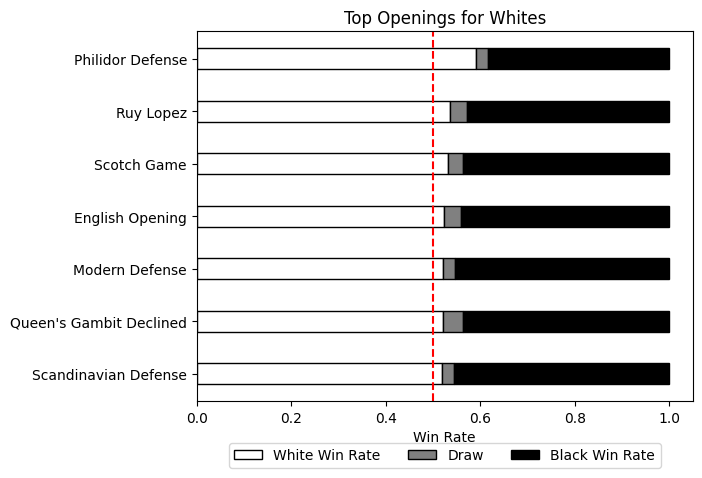

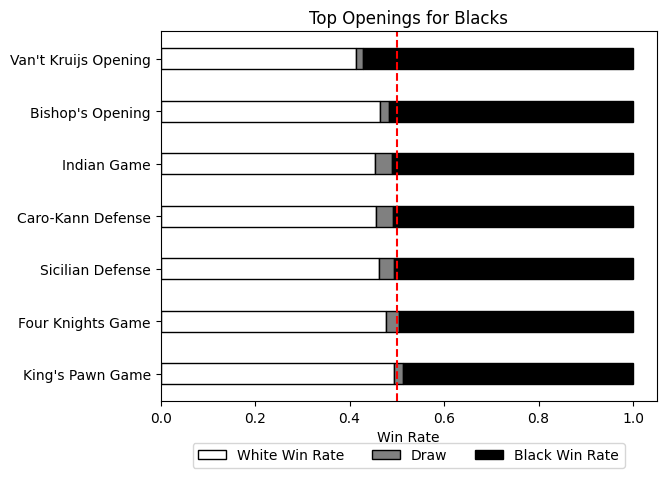

In [20]:
# Create horizontal bar plot for whites
create_horizontal_bar_plot(top_openings_white, 'Top Openings for Whites')

# Create horizontal bar plot for blacks
create_horizontal_bar_plot(top_openings_black, 'Top Openings for Blacks')


Of course, similar graphs may be obtained grouping by elo rating. However, the sample size for each opening would be too small to draw any meaningful conclusions. Furthermore, grouping by elo rating would not be as useful as grouping by color, as the elo rating of the opponent is not tied to the elo rating of the player. In this example, we (always) group by black elo rating. This is part of why top openings for black in GM rating always give a 100% win rate. Similarly, the top openings for white in GM rating never gives a 100% win rate because the opponent of black is not necessarily a GM.

This weird behavior can be removed if we filter openings that are only played a certain number of times. For example, if we only consider openings that are played at least 1000 times. But grouping by elo rating no longer reveals any new/unseen opening. 

In [21]:
threshold_count = 1_000  # set to 0 and GM black always wins for its top openings

# calculate win rates for each opening depending on color AND elo category
opening_win_rates_per_elo_and_color_dict = {}

opening_win_rates_per_elo_and_color = (
    df.groupBy("Cleaned_Opening", "Black_elo_category", "Result")
    .count()
    .groupBy("Cleaned_Opening", "Black_elo_category")
    .agg(
        F.sum("count").alias("total_games"),
        F.sum(F.when(F.col("Result") == "1-0", F.col("count")).otherwise(0)).alias(
            "white_wins"
        ),
        F.sum(F.when(F.col("Result") == "0-1", F.col("count")).otherwise(0)).alias(
            "black_wins"
        ),
        F.sum(F.when(F.col("Result") == "1/2-1/2", F.col("count")).otherwise(0)).alias(
            "draws"
        ),
    )
    .filter(F.col("total_games") >= threshold_count)  # filter by count threshold
    .withColumn("white_win_rate", F.col("white_wins") / F.col("total_games"))
    .withColumn("black_win_rate", F.col("black_wins") / F.col("total_games"))
    .withColumn("draw_rate", F.col("draws") / F.col("total_games"))
    .select(
        "Cleaned_Opening",
        "Black_elo_category",
        "white_win_rate",
        "black_win_rate",
        "draw_rate",
    )
    .fillna(0)  # replace NaN with 0 for cases where there are no wins
    .toPandas()  # convert to Pandas DataFrame for simplicity (this is less than 0.01MB in memory)
)


# Convert Pandas DataFrame to dictionary
for _, row in opening_win_rates_per_elo_and_color.iterrows():
    # dict is structured as follows:
    # elo_category -> same as before
    try:
        opening_win_rates_per_elo_and_color_dict[row["Black_elo_category"]][
            row["Cleaned_Opening"]
        ] = {
            "white": row["white_win_rate"],
            "black": row["black_win_rate"],
            "draw": row["draw_rate"],
        }
    except KeyError:
        opening_win_rates_per_elo_and_color_dict[row["Black_elo_category"]] = {
            row["Cleaned_Opening"]: {
                "white": row["white_win_rate"],
                "black": row["black_win_rate"],
                "draw": row["draw_rate"],
            }
        }

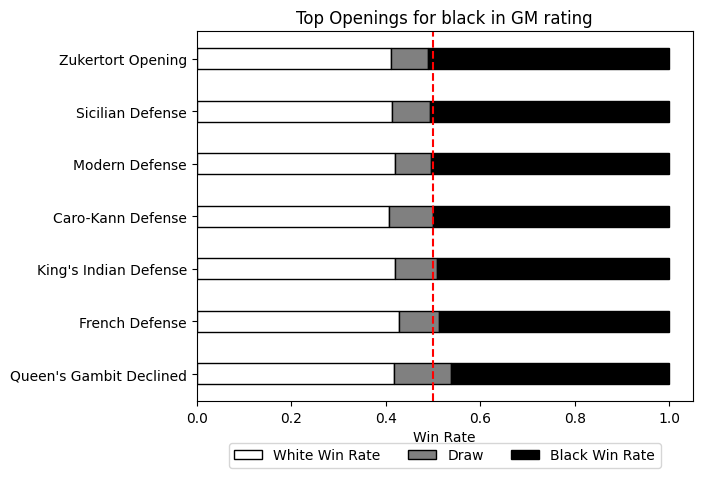

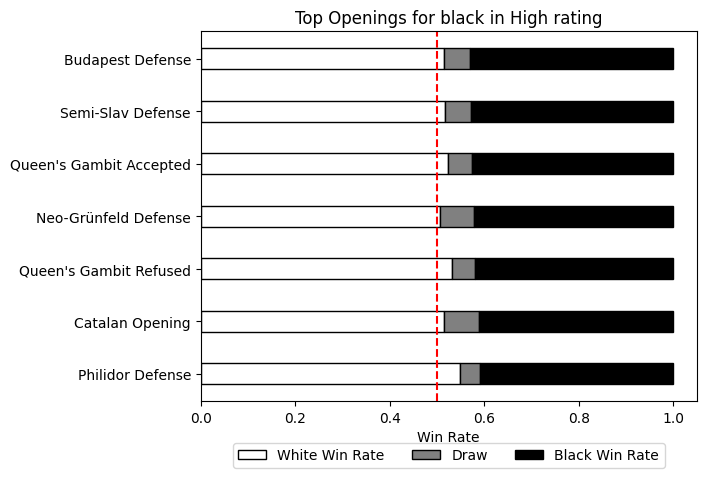

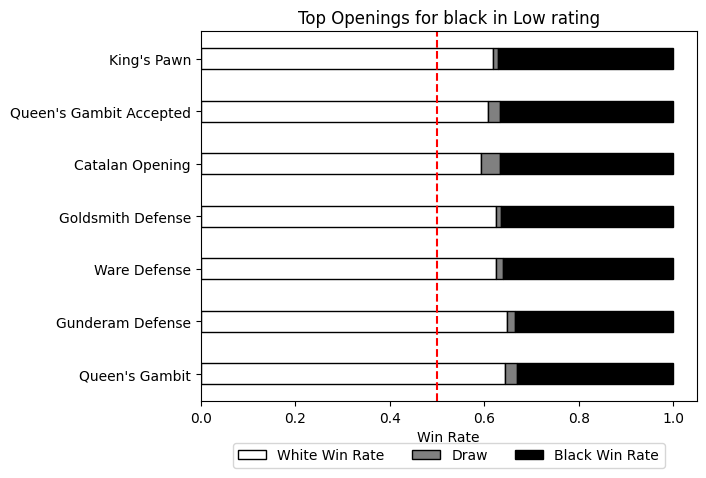

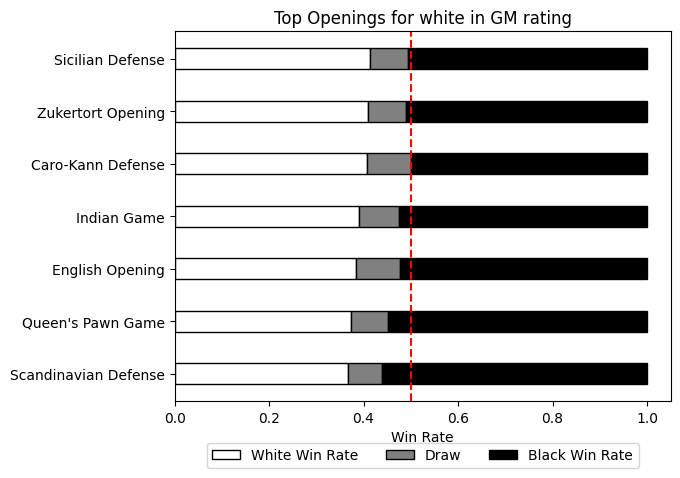

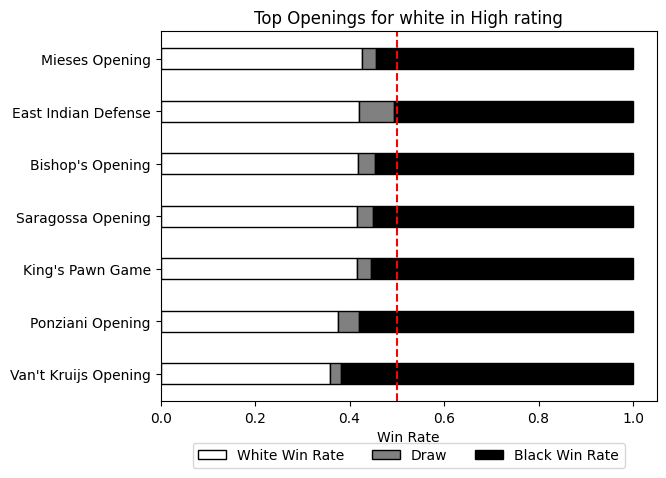

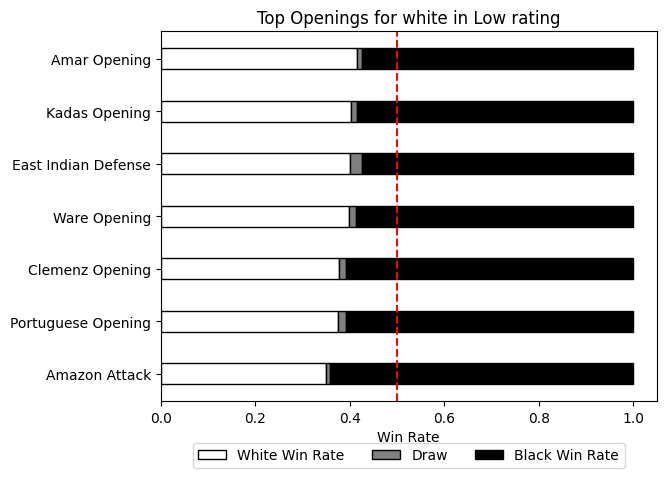

In [22]:
top_openings_dict: dict[tuple[str, str], dict[str, dict[str, float]]] = {}
top_openings_names: dict[str, set[str]] = {} # color -> set of opening names

for color in "black", "white":
    top_openings_names[color] = set()
    for elo_category in elo_categories:
        top_openings = list(
            reversed(
                sorted(
                    opening_win_rates_per_elo_and_color_dict.get(elo_category, {}).items(),
                    key=lambda x: x[1][color],
                    reverse=True,
                )
            )
        )
        top_openings_dict[(color, elo_category)] = dict(top_openings)
        top_openings_names[color].update([opening[0] for opening in top_openings])

        create_horizontal_bar_plot(
            top_openings[:top_openings_count], f"Top Openings for {color} in {elo_category}"
        )


Plotting the evolution here does not make any sense either. Most GM openings are played less than 1000 times so there is no "evolution" in proper terms.

In [23]:
def plot_evolution_win_rate(top_opening_evolution, title):
    _, ax = plt.subplots()

    # define colors for lines
    marker_colors = {"up": "green", "down": "red"}

    # iterate through each opening
    for opening, evolution in top_opening_evolution.items():
        # Extract elo categories and percentages
        categories = list(evolution.keys())[::-1]
        percentages = list(evolution.values())[::-1]

        # plot lines indicating the trend
        trend_color = (
            marker_colors["up"]
            if percentages[-1] > percentages[0]
            else marker_colors["down"]
        )
        ax.plot(
            categories,
            percentages,
            marker="",  # no marker
            linestyle="-",
            linewidth=2.5,  # increase line thickness
            label=opening,
            color=trend_color,
        )

        # annotate the first points with the opening name
        ax.annotate(
            opening,
            xy=(categories[0], percentages[0]),
            textcoords="offset points",
            xytext=(-30, 0),
            ha="right",
            va="bottom",
            color=trend_color,
        )
        ax.annotate(
            opening,
            xy=(categories[-1], percentages[-1]),
            textcoords="offset points",
            xytext=(30, 0),
            ha="left",
            va="bottom",
            color=trend_color,
        )

        # annotate the last points with the percentage values
        for i, (cat, perc) in enumerate(zip(categories, percentages)):
            ax.annotate(
                f"{perc:.1f}%",  # display percentage with one decimal place
                xy=(cat, perc),
                xytext=(0, 3),  # adjust text offset for better visibility
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,  # set font size for percentage labels
                color=trend_color,
            )

    ax.set_xlabel("Elo Categories")
    ax.set_ylabel("% of Use")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [24]:
for color in ("black", "white"):
    # use top_openings_dict: dict[tuple[str, str], list[tuple[str, dict[str, float]]]]
    for opening in top_openings_names[color]:
        for elo_category in elo_categories:
            win_rates = top_openings_dict[(color, elo_category)].get(opening, {})
            # print(f"{color} {elo_category} {opening} {win_rates}")

## 3. The players (and their moves)

For every game (as mentioned in paragraph 1) we have information about the moves made by the players such as:

1. How often did the balance in the game flip (based on changes in the evaluation of the game)
2. How many blunders, errors and inaccuracies in the game by each player (annotated by “??”/“?”/“?!” respectively in the lichess pgn)
3. How many moves were made under time pressure (remaining time less than 10% of the starting time)

### 3.1. How often do games flip?

Access to game evaluations enables the calculation of how often the balance of a game transitions between opposing sides. Specifically, we can track the occurrence of shifts in the game status among the following categories:

- The game is evenly matched, with evaluations ranging between -1 and 1.
- White is in a winning position, with evaluations above 1.
- Black is in a winning position, with evaluations below -1.

**It's essential to emphasize** that an evaluation indicating one side's advantage doesn't guarantee a corresponding outcome. The player must discover the crucial move, possibly just one, to sway the game in their favor!

For the purpose of clarity in data visualization, I have limited the sample to games where the balance shifts up to 20 times, as a higher frequency makes the plots challenging to interpret.

In [25]:
# define a function to calculate the 1st and 3rd quintiles
def quintiles(col_name):
    q1_expr = F.expr(f"percentile({col_name}, array(0.25))")
    q3_expr = F.expr(f"percentile({col_name}, array(0.75))")

    return q1_expr.getItem(0).alias("Q1"), q3_expr.getItem(0).alias("Q3")

# group by elo category, game type, and calculate various statistics
flips_per_game_df = (
    df.filter(F.col("Game_flips") <= 20)
    .groupBy("Black_elo_category", "Game_type")
    .agg(
        F.expr("mean(Game_flips)").alias("Mean_flips"),
        F.expr("percentile(Game_flips, array(0.5))").getItem(0).alias("Median_flips"),
        F.expr("min(Game_flips)").alias("Min_flips"),
        F.expr("max(Game_flips)").alias("Max_flips"),
        *quintiles("Game_flips"),
    )
    .orderBy("Black_elo_category", "Game_type")
)

flips_per_game_df.show()


+------------------+---------+-----------------+------------+---------+---------+---+---+
|Black_elo_category|Game_type|       Mean_flips|Median_flips|Min_flips|Max_flips| Q1| Q3|
+------------------+---------+-----------------+------------+---------+---------+---+---+
|         GM rating|    Blitz|5.055590750712702|         4.0|        0|       20|2.0|7.0|
|         GM rating|   Bullet|5.848717333972669|         5.0|        0|       20|3.0|8.0|
|         GM rating|Classical|3.723849372384937|         3.0|        0|       19|1.0|5.0|
|         GM rating|    Rapid|3.745594215996385|         3.0|        0|       20|1.0|5.0|
|       High rating|    Blitz|5.639461955912305|         5.0|        0|       20|2.0|8.0|
|       High rating|   Bullet|5.902125020606499|         5.0|        0|       20|3.0|8.0|
|       High rating|Classical|4.829915513069691|         4.0|        0|       20|2.0|7.0|
|       High rating|    Rapid|5.324143224375922|         4.0|        0|       20|2.0|8.0|
|        L

In [26]:
# create a dictionary to store game flips
game_flips_dict: dict[str, dict[str, list[int]]] = {}

# iterate through game types
for game_type in game_types:
    # create a sub-dictionary for the current game type
    game_flips_dict[game_type] = {}

    # filter the DataFrame for the current game type
    game_type_df = df.filter(F.col("Game_type") == game_type)

    # iterate through elo categories
    for elo_category in elo_categories:
        # filter the DataFrame for the current elo category
        elo_category_df = game_type_df.filter(
            F.col("Black_elo_category") == elo_category
        )

        # Collect the list of game flips
        game_flips = list(
            filter(lambda x: x <= 20,
            elo_category_df.select("Game_flips").rdd.flatMap(lambda x: x).collect()
            )
        )

        # add the list of game flips to the dictionary
        game_flips_dict[game_type][elo_category] = game_flips


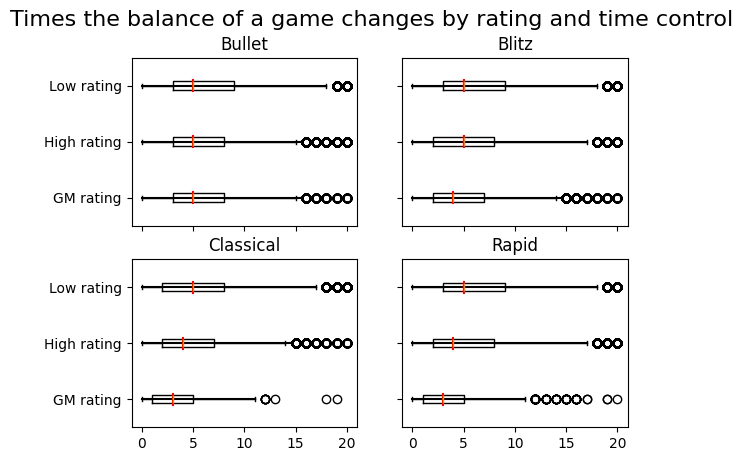

In [27]:
# create a figure with len(game_types) subplots arranged in a 2x(len(game_types) // 2) grid
fig, axs = plt.subplots((len(game_types)+1) // 2, 2, sharex=True, sharey=True)
fig.suptitle("Times the balance of a game changes by rating and time control", fontsize=16)

# iterate through game types
for i, (game_type, elo_categories_dict) in enumerate(game_flips_dict.items()):
    # calculate the subplot position (len(game_types) // 2 rows, 2 columns)
    row, col = i // 2, i % 2

    # select the subplot
    ax = axs[row, col]

    # iterate through elo categories
    for elo_category, game_flips in elo_categories_dict.items():
        # calculate quartiles and median
        q1, q3 = np.percentile(game_flips, [25, 75])
        median = np.median(game_flips)

        # Calculate upper and lower whiskers
        lower_whisker = max(np.min(game_flips), q1 - 1.5 * (q3 - q1))
        upper_whisker = min(np.max(game_flips), q3 + 1.5 * (q3 - q1))

        ax.boxplot(
            game_flips, positions=[elo_categories.index(elo_category) + 1], vert=False
        )
        ax.plot(
            [lower_whisker, upper_whisker],
            [
                elo_categories.index(elo_category) + 1,
                elo_categories.index(elo_category) + 1,
            ],
            color="black",
        )
        ax.plot(
            [median, median],
            [
                elo_categories.index(elo_category) + 0.9,
                elo_categories.index(elo_category) + 1.1,
            ],
            color="red",
        )
        ax.set_yticks(range(1, len(elo_categories) + 1))
        ax.set_yticklabels(elo_categories)
        ax.set_title(f"{game_type}")

plt.show()


Here are some noteworthy observations in the data:

- In bullet time controls, the median frequency of game flips remains relatively consistent across all three rating levels.
- The disparity between ratings becomes more apparent in longer time controls, with games rated by Grandmasters (GM) experiencing very few flips.
- Games with lower ratings exhibit a similar average number of flips, regardless of the time control.

Next, let's delve into the relationship between ELO rating and inaccurate moves, specifically focusing on blunders.

### 3.2. What is the relationship between ELO rating and inaccurate moves?

**Blunders**

For the upcoming sections of our analysis, I will introduce an additional category in the Elo rating groups, namely "Below 1000 rating." This addition is motivated by intriguing patterns observed within this category.

One initial inquiry revolves around understanding the correlation between ELO rating and the occurrence of blunders in a game. Ideally, a higher ELO rating should result in fewer blunders. To ensure a fair comparison, we will examine blunders per move, taking into consideration the varying lengths of the games.

In [28]:
# introduce a new column with elo category that is "bellow 1000"
def get_new_elo_category(elo_category: str, elo: int) -> str:
    if elo < 1000:
        return "Below 1000"
    return elo_category

get_new_elo_category_udf = F.udf(get_new_elo_category, StringType())
df = df.withColumn("New_Black_elo_category", get_new_elo_category_udf(df["Black_elo_category"], df["BlackElo"]))

df.groupBy("New_Black_elo_category").count().show()
new_elo_categories = ["Below 1000"] + elo_categories[::-1]


+----------------------+-------+
|New_Black_elo_category|  count|
+----------------------+-------+
|            Below 1000| 121616|
|             GM rating|  40584|
|           High rating| 706089|
|            Low rating|2861276|
+----------------------+-------+



In [29]:
# average blunders per move by rating and time control
average_blunders_dict: dict[str, dict[str, float]] = {}

# iterate through game types
for game_type in game_types:
    # create a sub-dictionary for the current game type
    average_blunders_dict[game_type] = {}

    # filter the DataFrame for the current game type
    game_type_df = df.filter(F.col("Game_type") == game_type)

    # iterate through elo categories
    for elo_category in new_elo_categories:
        # calculate the average blunders per move
        # based on black blunders + white blunders and number of moves
        average_blunders = (
            game_type_df.filter(F.col("New_Black_elo_category") == elo_category)
            .select(
                ((F.sum("Black_blunders") + F.sum("White_blunders")) / F.sum("Total_moves")).alias("avg_blunders_per_move")
            )
            .agg(F.avg("avg_blunders_per_move").alias("average_blunders"))
            .collect()[0]["average_blunders"]
        )

        # add the average blunders to the dictionary
        average_blunders_dict[game_type][elo_category] = average_blunders


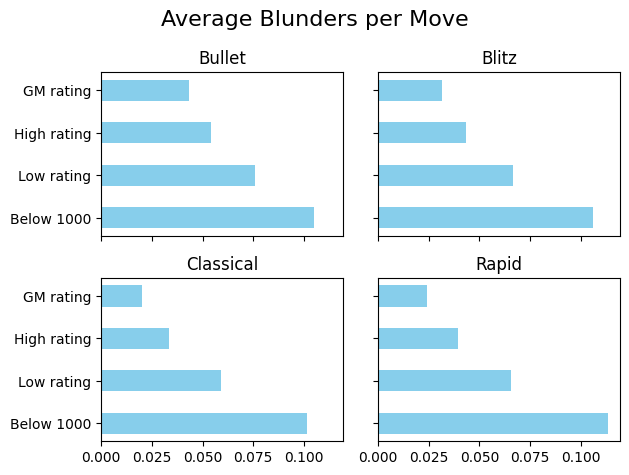

In [30]:
# create a figure with len(game_types) subplots arranged in a 2x(len(game_types) // 2) grid
fig, axs = plt.subplots((len(game_types)+1) // 2, 2, sharex=True, sharey=True)
fig.suptitle("Average Blunders per Move", fontsize=16)

bar_width = 0.5
# iterate through game types
for i, (game_type, elo_categories_dict) in enumerate(game_flips_dict.items()):
    # calculate the subplot position (len(game_types) // 2 rows, 2 columns)
    row, col = i // 2, i % 2

    # select the subplot
    ax = axs[row, col]

    avg_blunders = [average_blunders_dict[game_type][elo] for elo in new_elo_categories]
    y_pos = np.arange(len(new_elo_categories))

    ax.barh(y_pos, avg_blunders, bar_width, align="center", color="skyblue")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(new_elo_categories)
    ax.set_title(game_type)

plt.tight_layout()
plt.show()


The chart reveals distinct trends:

- The frequency of blunders per move notably diminishes with increasing rating levels, with Grandmaster (GM) players demonstrating the fewest blunders. Moreover, this trend intensifies as the time control lengthens.
- Players with higher ratings effectively utilize the allotted time, resulting in a reduction of blunders when compared to games with faster time controls.

While these findings provide valuable insights, a more detailed exploration of the correlation between Elo rating and blunders would enhance our understanding.

In [31]:
# average blunders per move by rating and time control
blunders_per_moves: dict[str, list[tuple[int, float]]] = {}

# iterate through game types
for game_type in game_types:
    # create a sub-dictionary for the current game type
    blunders_per_moves[game_type] = []

    # filter the DataFrame for the current game type
    game_type_df = df.filter(F.col("Game_type") == game_type)

    # populate the dict with all (BlackElo, Black_blunders / Total_moves) pairs
    blunders_per_moves[game_type] = (
        game_type_df.select(
            ((F.col("Black_blunders") + F.col("White_blunders")) / F.col("Total_moves")).alias("blunders_per_move"),
            "BlackElo",
        )
        .orderBy("BlackElo")
        .rdd.map(lambda x: (x["BlackElo"], x["blunders_per_move"]))
        .collect()
    )


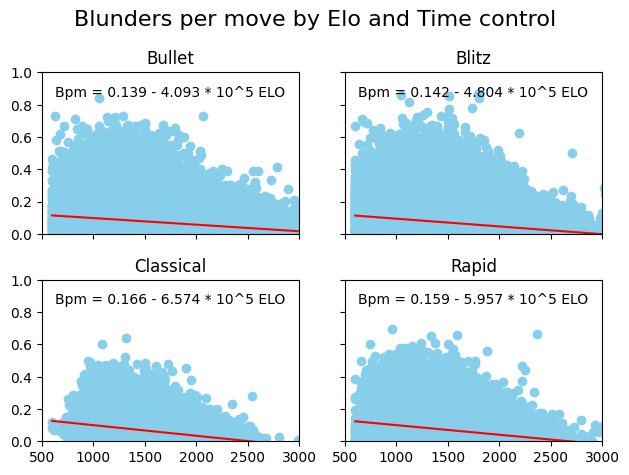

In [32]:
# create a figure with len(game_types) subplots arranged in a 2x(len(game_types) // 2) grid
fig, axs = plt.subplots((len(game_types)+1) // 2, 2, sharex=True, sharey=True)
fig.suptitle("Blunders per move by Elo and Time control", fontsize=16)

# iterate through game types
for i, (game_type, elo_blunder_list) in enumerate(blunders_per_moves.items()):
    # calculate the subplot position (len(game_types) // 2 rows, 2 columns)
    row, col = i // 2, i % 2

    # select the subplot
    ax = axs[row, col]

    # extract elo and blunders_per_move
    elo, blunders_per_move = zip(*elo_blunder_list)

    # scatter plot
    ax.scatter(elo, blunders_per_move, color="skyblue")
    ax.set_title(game_type)

    # plot a line of best fit
    m, b = np.polyfit(elo, blunders_per_move, 1)
    ax.plot(elo, m * np.array(elo) + b, color="red")

    # display the equation
    sign = "+" if m > 0 else "-"
    ax.text(
        0.05, 0.85, f"Bpm = {b:.3f} {sign} {1e5 * abs(m):.3f} * 10^5 ELO", transform=ax.transAxes
    )

    # set x and y limits
    ax.set_xlim(500, 3000)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


A clear negative correlation emerges when examining the relationship between Blunders per Move and Elo rating. This trend is evident not only by observing the slope of the lines but also by considering the coefficients of the linear regression lines displayed prominently on the charts. Notably, Classical games exhibit the most pronounced downward trend.

**What about lesser mistakes?**

While blunders represent the most critical mistakes in a game, they are not the sole focus. Drawing insights from Lichess game annotations, we categorize mistakes into three types: blunders (the most severe), errors (serious mistakes), and inaccuracies. Our dataset includes data for all three move categories, collectively termed "inferior moves" (the sum of blunders, errors, and inaccuracies made by each player in a game). Let's explore the correlation between these inferior moves and the Elo rating of the players.

In [33]:
inferior_moves_per_moves: dict[str, list[tuple[int, float]]] = {}

# iterate through game types
for game_type in game_types:
    # create a sub-dictionary for the current game type
    inferior_moves_per_moves[game_type] = []

    # filter the DataFrame for the current game type
    game_type_df = df.filter(F.col("Game_type") == game_type)

    # populate the dict with all (BlackElo, Black_blunders + Black_mistakes + Black_inaccuracies  / Total_moves) pairs
    inferior_moves_per_moves[game_type] = (
        game_type_df.select(
            ((F.col("Black_inferior_moves") + F.col("White_inferior_moves")) / F.col("Total_moves")).alias("inferior_moves_per_move"),
            "BlackElo",
        )
        .orderBy("BlackElo")
        .rdd.map(lambda x: (x["BlackElo"], x["inferior_moves_per_move"]))
        .collect()
    )


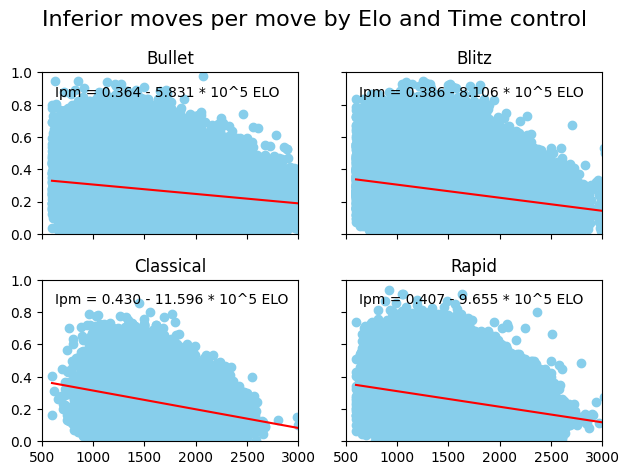

In [34]:
# create a figure with len(game_types) subplots arranged in a 2x(len(game_types) // 2) grid
fig, axs = plt.subplots((len(game_types)+1) // 2, 2, sharex=True, sharey=True)
fig.suptitle("Inferior moves per move by Elo and Time control", fontsize=16)

# iterate through game types
for i, (game_type, elo_inferior_moves_list) in enumerate(inferior_moves_per_moves.items()):
    # calculate the subplot position (len(game_types) // 2 rows, 2 columns)
    row, col = i // 2, i % 2

    # select the subplot
    ax = axs[row, col]

    # extract elo and inferior_moves_per_move
    elo, inferior_moves_per_move = zip(*elo_inferior_moves_list)

    # scatter plot
    ax.scatter(elo, inferior_moves_per_move, color="skyblue")
    ax.set_title(game_type)

    # plot a line of best fit
    m, b = np.polyfit(elo, inferior_moves_per_move, 1)
    ax.plot(elo, m * np.array(elo) + b, color="red")

    # display the equation
    sign = "+" if m > 0 else "-"
    ax.text(
        0.05, 0.85, f"Ipm = {b:.3f} {sign} {1e5 * abs(m):.3f} * 10^5 ELO", transform=ax.transAxes
    )

    # # set x and y limits
    ax.set_xlim(500, 3000)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


The distinctions become more evident in this analysis. Across all rating categories, the incline of the curve is steeper compared to that observed solely for blunders. This suggests a compelling indication of an inverse relationship between suboptimal move choices and Elo rating—fortunately confirming our expectations.

### 3.3. How does time pressure affect the move quality?

The distinctions become more evident in this analysis. Across all rating categories, the incline of the curve is steeper compared to that observed solely for blunders. This suggests a compelling indication of an inverse relationship between suboptimal move choices and Elo rating—fortunately confirming our expectations.
3.3) Impact of Time Pressure on Move Quality

Time stands as a critical factor in chess, transforming the game into an optimization challenge where one must discover optimal moves within the allotted time. While objectively superior moves are ideal, they may not be practical if they consume a significant portion of the available time. This aspect becomes particularly pronounced in faster time controls, where players must maneuver their pieces swiftly.

An intriguing inquiry emerges: Do players tend to make more subpar moves in time scrambles compared to regular play? To explore this, the analysis focuses on categorizing suboptimal moves as either blunders or mistakes, exclusively examining games where one or both players execute moves with minimal time remaining on the clock.

In [35]:
# sub dataset for games where Black_ts_moves > 0 or White_ts_moves > 0
ts_df = df.filter((F.col("Black_ts_moves") > 0) | (F.col("White_ts_moves") > 0))


In [36]:
# for each game type, for each (new) elo category
# store the average number of errors per move and the average number of errors per move with short time remaining
# Black_mistakes + White_mistakes / Total_moves
# Black_ts_mistakes + White_ts_mistakes / Black_ts_moves + White_ts_moves
mistakes_per_moves: dict[str, dict[str, tuple[float, float]]] = {}

# iterate through game types
for game_type in game_types:
    # create a sub-dictionary for the current game type
    mistakes_per_moves[game_type] = {}

    # filter the DataFrame for the current game type
    game_type_df = ts_df.filter(F.col("Game_type") == game_type)

    # iterate through elo categories
    for elo_category in new_elo_categories:
        # calculate the average number of mistakes per move
        # based on Black_mistakes + White_mistakes and number of moves
        average_mistakes = (
            game_type_df.filter(F.col("New_Black_elo_category") == elo_category)
            .select(
                ((F.sum("Black_mistakes") + F.sum("Black_blunders") + F.sum("White_mistakes") + F.sum("White_blunders")) / F.sum("Total_moves")).alias("avg_mistakes_per_move"),
                ((F.sum("Black_ts_mistakes") + F.sum("Black_ts_blunders") + F.sum("White_ts_mistake") + F.sum("White_ts_blunders")) / (F.sum("Black_ts_moves") + F.sum("White_ts_moves"))).alias("avg_mistakes_per_move_ts"),
            )
            .agg(F.avg("avg_mistakes_per_move").alias("average_mistakes"), F.avg("avg_mistakes_per_move_ts").alias("average_mistakes_ts"))
            .collect()[0]
        )

        # add the average blunders to the dictionary
        mistakes_per_moves[game_type][elo_category] = (average_mistakes["average_mistakes"], average_mistakes["average_mistakes_ts"])


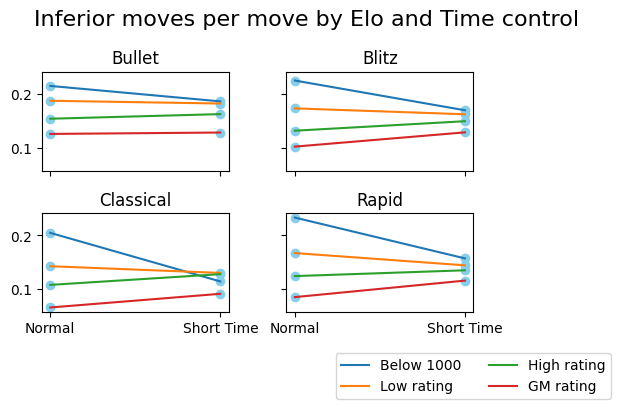

In [37]:
# create a figure with len(game_types) subplots arranged in a 2x(len(game_types) // 2) grid
fig, axs = plt.subplots((len(game_types)+1) // 2, 2, sharex=True, sharey=True)
fig.suptitle("Inferior moves per move by Elo and Time control", fontsize=16)

# iterate through game types
for i, (game_type, mistakes_comparison_dict) in enumerate(mistakes_per_moves.items()):
    # calculate the subplot position (len(game_types) // 2 rows, 2 columns)
    row, col = i // 2, i % 2

    # select the subplot
    ax = axs[row, col]

    for elo_category, (avg_mistakes, avg_mistakes_ts) in mistakes_comparison_dict.items():
        # plot 2 points for each elo category, one at x=0 and one at x=1
        # and connect them with a line
        ax.plot([0, 1], [avg_mistakes, avg_mistakes_ts], label=elo_category)
        ax.scatter([0, 1], [avg_mistakes, avg_mistakes_ts], color="skyblue")

    ax.set_title(game_type)
    # replace x ticks with labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Normal", "Short Time"])


# single legend for the entire figure
plt.legend(bbox_to_anchor=(1, -0.95), loc="lower center", ncol=(len(new_elo_categories)+1)//2)

plt.tight_layout()
plt.show()


Here are some intriguing observations from the data charts:

1. It's quite fascinating to note that for Elo ratings below 1,000, **having more time seems to result in more mistakes**. This unexpected trend could be attributed to players potentially overthinking their moves, possibly due to a lack of familiarity with various openings.
2. In the case of lower-rated players, ranging from 1000 to 1900 rating, time pressure doesn't seem to significantly impact their performance. The line representing lower ratings remains relatively horizontal across all time controls.
3. Conversely, higher-rated players exhibit a tendency to make more errors per move when under time pressure compared to situations where they have ample time available. This suggests an interesting dynamic in how time constraints affect players of varying skill levels.

## 4. Predicting the game outcome based on the available information

Examining the feasibility of predicting chess match outcomes brings forth an intriguing inquiry: How effectively can we anticipate the result of a chess game? To tackle this, we leverage the wealth of information at our disposal in the dataset. This endeavor manifests as a classification problem with three distinct categories: Victory for White (1-0), Draw (1/2-1/2), or Victory for Black (0-1).

To address this challenge, I used a random forest model utilizing the ranger package. In its first iteration, the model incorporates the following variables:

- Starting time
- Increment
- Total moves
- ECO (Opening classification)
- White ELO (Rating of the white player)
- White blunders
- White mistakes
- White inaccuracies
- Black ELO (Rating of the black player)
- Black blunders
- Black mistakes
- Black inaccuracies


In [38]:
selected_features = [
    "starting_time", "increment", "Total_moves", "ECO",
    "WhiteElo", "White_blunders", "White_mistakes", "White_inaccuracies",
    "BlackElo", "Black_blunders", "Black_mistakes", "Black_inaccuracies"
]

df_selected = df.select(*selected_features, "Result")

# drop rows where Result is *
df_selected = df_selected.filter(df_selected.Result != "*")


In [39]:
# indexing the 'ECO' column
indexer = StringIndexer(inputCol="ECO", outputCol="ECO_index")
df_selected = indexer.fit(df_selected).transform(df_selected)

# dropping the 'ECO' column
df_selected = df_selected.drop("ECO")
selected_features.remove("ECO")
selected_features.append("ECO_index")

# renaming the 'Result' column to 'label'
df_selected = df_selected.withColumnRenamed("Result", "label")

# splitting the data into training and testing sets
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)


In [40]:
# converting to pandas for sklearn
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()


In [41]:
# instantiate the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


In [42]:
# fit the model (eta: ~10min)
rf_classifier.fit(train_data_pd[selected_features], train_data_pd["label"])


RandomForestClassifier(random_state=42)

In [43]:
# making predictions
predictions = rf_classifier.predict(test_data_pd[selected_features])


In [44]:
# evaluating the model
conf_matrix = confusion_matrix(test_data_pd["label"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
report = classification_report(test_data_pd["label"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
print(report)


              precision    recall  f1-score   support

         1-0       0.85      0.87      0.86    370895
     1/2-1/2       0.59      0.14      0.23     21741
         0-1       0.84      0.86      0.85    352144

    accuracy                           0.85    744780
   macro avg       0.76      0.63      0.65    744780
weighted avg       0.84      0.85      0.84    744780



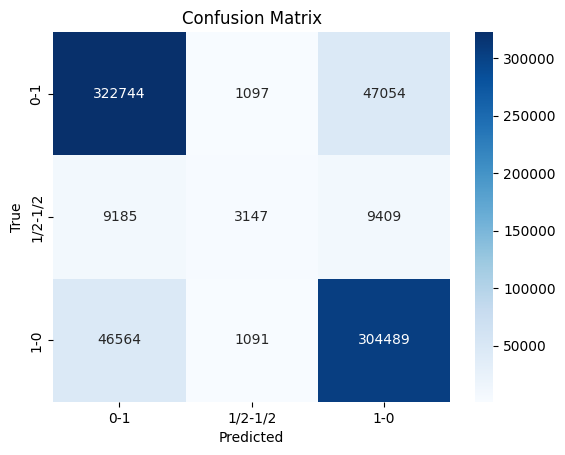

In [45]:
# plotting the confusion matrix
plt.figure()
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["0-1", "1/2-1/2", "1-0"],
    yticklabels=["0-1", "1/2-1/2", "1-0"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


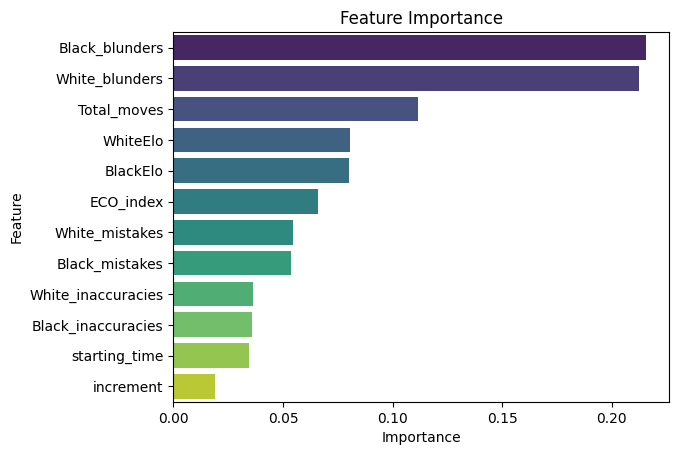

In [46]:
# feature importance
feature_importance = rf_classifier.feature_importances_
features_df = pd.DataFrame(
    {"Feature": selected_features, "Importance": feature_importance}
)
features_df = features_df.sort_values(by="Importance", ascending=False)

plt.figure()
sns.barplot(x="Importance", y="Feature", data=features_df, palette="viridis", hue="Feature")
plt.title("Feature Importance")
plt.show()


Before delving into the analysis of the plots, let's take a moment to understand the information they present:

- **Confusion Matrix**: As the name suggests, the confusion matrix displays instances where the model mistakenly identifies one class for another. A careful review of this matrix provides insights into specific areas of the dataset that require closer attention.

- **Feature Importance Plot**: The interpretation of feature importance varies based on the algorithm employed in the model. In our case, we utilize random forests, which consist of numerous decision trees. The algorithm aims to reduce the variance of a single decision tree by introducing randomness in two ways:
    - **Method 1**: Randomly sampling with replacement from the training set.
    - **Method 2**: Randomly selecting and restricting available predictors for each split in the decision tree.
    
    After creating this ensemble of trees, the random forest makes predictions through a "voting system" from individual decision trees, with the most voted class being the final prediction. The importance of each feature is determined by assessing, on average across all decision trees, how effective a split based on the selected feature is in achieving dataset homogeneity. In the context of chess, a good split example would be one where all games on one side of the split are wins for black, and on the other side, all games are draws.

- **Per Class Statistics**: While overall model statistics provide a general assessment, per-class statistics offer a deeper understanding of prediction shortcomings for each class.

Enough theory! Let's examine the practical output of our model.

The random forest output is intriguing and offers avenues for improvement. While the overall model accuracy stands at approximately 85%, there's more to explore. Notably, the confusion matrix and statistics reveal that the model struggles with predicting draws. This might be attributed to the infrequent occurrence of draws in our dataset, and the need for balancing the three classes wasn't addressed.

The feature importance plot also highlights that the opening choice doesn't significantly contribute to predicting game outcomes. As anticipated (to prevent certain openings from dominating), we can consider excluding openings in the next model iteration.

Lastly, we must acknowledge the inherent unpredictability in chess, particularly in online settings with fast time controls. Cases of mouseslips, time constraints, or the common scenario of making a single mistake in a winning game leading to a sudden loss contribute to the challenging nature of predicting chess outcomes.

In [47]:
del df_selected, train_data, test_data, train_data_pd, test_data_pd
del rf_classifier, predictions, conf_matrix, report, feature_importance, features_df
del blunders_per_moves, inferior_moves_per_moves
gc.collect()


5105

In the upcoming iteration of our predictive model, we aim to tackle several challenges by implementing the following enhancements:

1. Incorporating SMOTE resampling to mitigate the scarcity of drawn games.
2. Excluding the opening from the model input to streamline and refine the training process.
3. Integrating moves during time scrambles into the model, providing a valuable addition to help identify instances where a player may be running low on time.

In [48]:
selected_features = [
    "starting_time", "increment", "Total_moves",
    "WhiteElo", "White_blunders", "White_mistakes", "White_inaccuracies",
    "BlackElo", "Black_blunders", "Black_mistakes", "Black_inaccuracies",
    "White_long_moves", "Black_long_moves", "White_ts_moves", "Black_ts_moves",
]

df_selected = df.select(*selected_features, "Result")

# drop rows where Result is *
df_selected = df_selected.filter(df_selected.Result != "*")


In [49]:
# renaming the 'Result' column to 'label'
df_selected = df_selected.withColumnRenamed("Result", "label")

# splitting the data into training and testing sets
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)


In [50]:
# converting to pandas for sklearn
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()


In [52]:
# doing SMOTE stuff
# the objective is to oversample the minority class (draws)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_data_pd[selected_features], train_data_pd["label"])
X_res = pd.DataFrame(X_res, columns=selected_features)
y_res = pd.DataFrame(y_res, columns=["label"])

In [53]:
# instantiate the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


In [54]:
# fit the model (eta: ~10min)
rf_classifier.fit(X_res, y_res)


/home/PI_2023_EI/.conda/envs/tps/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [55]:
# making predictions
predictions = rf_classifier.predict(test_data_pd[selected_features])


In [56]:
# evaluating the model
conf_matrix = confusion_matrix(test_data_pd["label"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
report = classification_report(test_data_pd["label"], predictions, labels=["1-0", "1/2-1/2", "0-1"])
print(report)


              precision    recall  f1-score   support

         1-0       0.91      0.86      0.88    370895
     1/2-1/2       0.23      0.59      0.33     21741
         0-1       0.90      0.86      0.88    352144

    accuracy                           0.85    744780
   macro avg       0.68      0.77      0.70    744780
weighted avg       0.88      0.85      0.86    744780



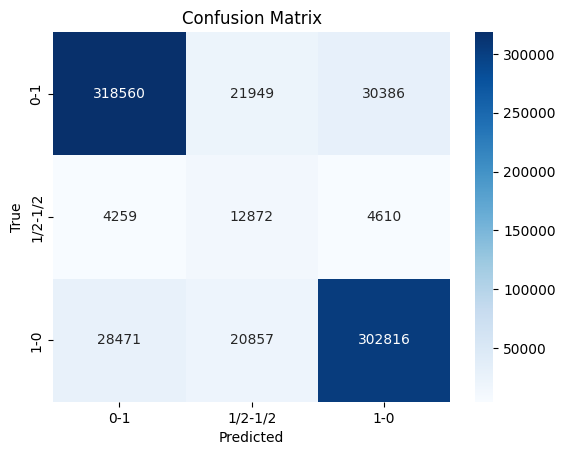

In [57]:
# plotting the confusion matrix
plt.figure()
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["0-1", "1/2-1/2", "1-0"],
    yticklabels=["0-1", "1/2-1/2", "1-0"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


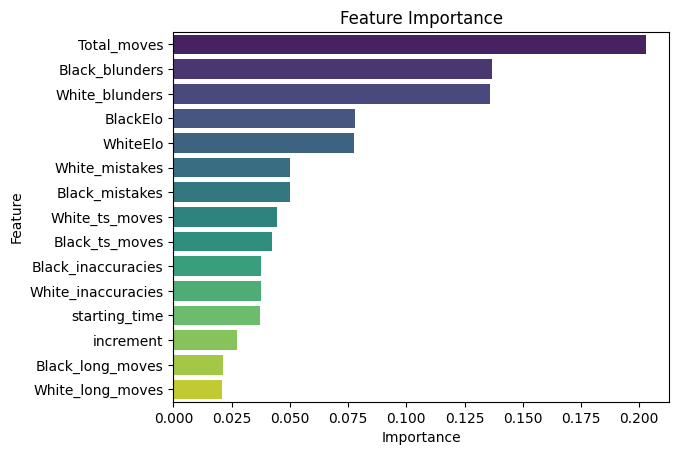

In [58]:
# feature importance
feature_importance = rf_classifier.feature_importances_
features_df = pd.DataFrame(
    {"Feature": selected_features, "Importance": feature_importance}
)
features_df = features_df.sort_values(by="Importance", ascending=False)

plt.figure()
sns.barplot(x="Importance", y="Feature", data=features_df, palette="viridis", hue="Feature")
plt.title("Feature Importance")
plt.show()


**The results exhibit notable shifts!**

The model demonstrates improved proficiency in recognizing white or black wins; however, this improvement is accompanied by a reduction in overall model accuracy. The significance of this trade-off depends on the specific goals of the model, which may be desirable or not based on the intended outcomes. Drawn games recall is slightly higher, but the precision is lower, indicating that the model is more likely to incorrectly predict a draw. This is a trade-off that we can accept, as it might be preferable to predict a draw when the game is a win for white or black, rather than the other way around.

In addition, there's a noteworthy alteration in the feature importance hierarchy: the total number of moves now takes the top spot. This suggests that the total number of moves plays a pivotal role in _correctly_ identifying drawn games. Notably, its prominence is heightened due to our SMOTE intervention.


## 5. Future considerations

Conducting this analysis was both enjoyable and insightful, yet it merely scratches the surface of the rich dataset at our disposal. Exploring the impact of substantial time investments on move effectiveness could unveil intriguing insights—perhaps revealing a correlation between time dedication and reduced mistakes. Another avenue worth exploring is identifying the openings that lead to the most significant ELO rating boosts for players. Alternatively, approaching the analysis from a fresh perspective might uncover hidden patterns.

Considering dataset enhancements, a valuable addition could be the identification of the player responsible for the last blunder in a game. While this attribute isn't currently included in the dataset, incorporating it could prove valuable for predictive modeling.